# Pylops-distributed - basic linear operators

In this notebook I will show how to use some of the basic linear operators implemented in *Pylops-distributed*.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import dask.array as da
import pylops
import pylops_distributed

from pylops.utils import dottest

Local cluster

In [ ]:
client = pylops_distributed.utils.backend.dask(processes=False, threads_per_worker=2,
                                               n_workers=2)
client

SSH cluster

In [2]:
from dask.distributed import Scheduler, Client

client = Client('be-linrgsn045:8786')

In [3]:
client

Client Scheduler: tcp://be-linrgsn045:8786 Dashboard: http://be-linrgsn045:8787/status,Cluster Workers: 4 Cores: 60 Memory: 541.16 GB


## Diagonal

Pylops

In [4]:
n = 100000
x = np.ones(n)
d = np.arange(n) + 1
Dop = pylops.Diagonal(d)
dottest(Dop, n, n, verb=True)

y  = Dop*x
y1 = Dop.H*y
xinv = Dop / y

print('D*x  = ',y)
print('D\'*x = ',y1)
print('D / y = ',xinv)

Dot test passed, v^T(Opu)=-7207423.445539 - u^T(Op^Tv)=-7207423.445539
D*x  =  [1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]
D'*x =  [1.0000e+00 4.0000e+00 9.0000e+00 ... 9.9996e+09 9.9998e+09 1.0000e+10]
D / y =  [4.09995980e-07 1.63998320e-06 3.68995950e-06 ... 9.99280430e-01
 9.99063740e-01 9.98822308e-01]


Pylops-distributed with lazy evaluation for forward and adjoint

In [10]:
xda = da.ones(n, chunks=(n//4,))
dda = da.from_array(d, chunks=(n//4,))

Ddaop = pylops_distributed.Diagonal(dda, compute=(False, False))
dottest(Ddaop, n, n, verb=True)

yda  = Ddaop.matvec(xda)
y1da = Ddaop.rmatvec(yda)
xinvda = Ddaop.div(yda, niter=5)

print('Diagonal > ', Ddaop.Op.diag)
print('D*x  = ',yda, yda.compute())
print('D\'*x = ',y1da, y1da.compute())
print('D / y = ',xinvda, xinvda.compute())

<100000x100000 Diagonal with dtype=float64>
Dot test passed, v^T(Opu)=-1009233.675054 - u^T(Op^Tv)=-1009233.675054
Diagonal >  dask.array<array, shape=(100000,), dtype=int64, chunksize=(25000,)>
D*x  =  dask.array<mul, shape=(100000,), dtype=float64, chunksize=(25000,)> [1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]
D'*x =  dask.array<mul, shape=(100000,), dtype=float64, chunksize=(25000,)> [1.0000e+00 4.0000e+00 9.0000e+00 ... 9.9996e+09 9.9998e+09 1.0000e+10]
D / y =  dask.array<add, shape=(100000,), dtype=float64, chunksize=(25000,)> [1.49998500e-09 5.99994000e-09 1.34998650e-08 ... 1.08508832e+00
 1.08515221e+00 1.08521612e+00]


In [12]:
xda

dask.array<ones, shape=(100000,), dtype=float64, chunksize=(25000,)>

In [13]:
yda.persist()

dask.array<mul, shape=(100000,), dtype=float64, chunksize=(25000,)>

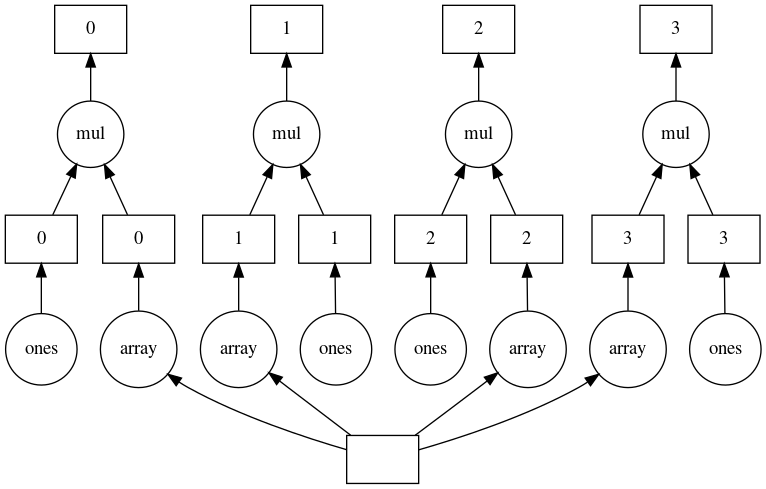

In [14]:
yda.visualize()

In [ ]:
# invda.visualize()

Pylops-distributed with compute for forward and adjoint

In [22]:
xda = da.ones(n, chunks=(n//4,))
dda = da.from_array(d, chunks=(n//4,))
True
Ddaop = pylops_distributed.Diagonal(dda, compute=(True, True))
dottest(Ddaop, n, n, verb=True)

yda  = Ddaop.matvec(xda)
y1da = Ddaop.rmatvec(yda)
xinvda = Ddaop.div(yda, niter=10)

print('Diagonal > ', Ddaop.Op.diag)
print('D*x  = ',yda)
print('D\'*x = ',y1da)
print('D / y = ',xinvda)

<100000x100000 Diagonal with dtype=float64>
Dot test passed, v^T(Opu)=10510634.116087 - u^T(Op^Tv)=10510634.116087
Diagonal >  dask.array<array, shape=(100000,), dtype=int64, chunksize=(25000,)>
D*x  =  [1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]
D'*x =  [1.0000e+00 4.0000e+00 9.0000e+00 ... 9.9996e+09 9.9998e+09 1.0000e+10]
D / y =  [4.99995001e-09 1.99997999e-08 4.49995495e-08 ... 9.64968641e-01
 9.64880728e-01 9.64792708e-01]


Comparision

In [25]:
%timeit -n 10 -r 3 Dop.matvec(x)
%timeit -n 10 -r 3 Ddaop.matvec(xda)

445 µs ± 12.1 µs per loop (mean ± std. dev. of 3 runs, 10 loops each)
32.7 ms ± 1.82 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


Finally we do the same with multiple dimensions

In [32]:
nother = 500

# serial
Dop = pylops.Diagonal(d, dir=1, dims=(nother, n))
print('Diagonal > ', Dop.diag)

x = np.ones((nother, n))
y = (Dop*x.flatten()).reshape(nother, n)
print('D*x  = \n',y)

# distributed
Ddaop = pylops_distributed.Diagonal(dda, dir=1, dims=(nother, n))
print('Diagonal > ', Ddaop.Op.diag)

xda = da.ones((nother, n), chunks=(nother, n//4))
yda = Ddaop.matvec(xda.flatten())
print('D*x  = ',y,'\n', yda.compute().reshape(nother, n))

Diagonal >  [[     1      2      3 ...  99998  99999 100000]]
D*x  = 
 [[1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]
 [1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]
 [1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]
 ...
 [1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]
 [1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]
 [1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]]
<50000000x50000000 Diagonal with dtype=float64>
Diagonal >  dask.array<reshape, shape=(1, 100000), dtype=int64, chunksize=(1, 25000)>
D*x  =  [[1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]
 [1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]
 [1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]
 ...
 [1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e+04 9.9999e+04 1.0000e+05]
 [1.0000e+00 2.0000e+00 3.0000e+00 ... 9.9998e

In [35]:
xda

dask.array<ones, shape=(500, 100000), dtype=float64, chunksize=(500, 25000)>

In [34]:
%timeit -n 10 -r 3 Dop.matvec(x.flatten())
%timeit -n 10 -r 3 Ddaop.matvec(xda.flatten()).compute()

218 ms ± 3.71 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)
4.91 s ± 212 ms per loop (mean ± std. dev. of 3 runs, 10 loops each)


In [36]:
client.close()